AYKIRI VERİ ANALİZİ

In [13]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


def show_outliers(df):
    sns.set_theme(style="whitegrid")
    for col in df.columns:
        if df[col].dtypes in ["float","int","int64","float64"]:
            ax = sns.boxplot(x=df[col])
            plt.show()

def show_related(df):
    for col in df.columns:
        if df[col].dtypes in ["float", "int"]:
            ax = sns.scatterplot(data=df, x="price", y=col,hue="cut")
            plt.show()
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.select_dtypes(include='number').quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def scale_and_pca(df):
    df_ = pd.get_dummies(df,drop_first=True)
    column_names = df_.columns
    scaler = StandardScaler()
    df_ = scaler.fit_transform(df_)
    df_ = pd.DataFrame(df_,columns=column_names)
    pca = PCA(n_components=1)
    cc = pca.fit_transform(df_.drop(["price"],axis=1), df_["price"])
    ax = sns.scatterplot(x=df_["price"], y=cc[:,0])
    plt.show()
    df["pca"] = cc[:,0]
    return df, df_

In [14]:
df = sns.load_dataset("diamonds")

In [15]:
# Hızlı bir şekilde verimizin bazı özelliklerine göz atalım
check_df(df)

##################### Shape #####################
(53940, 10)
##################### Types #####################
carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object
##################### Head #####################
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
##################### Tail #####################
       carat        cut color clarity  depth  table  price     x     y     z
53935   0.72      Ideal     D     SI1   60.8   57.0   2757  5.75  5.76  3

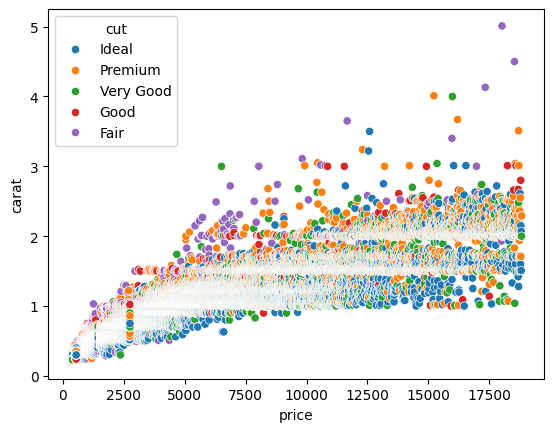

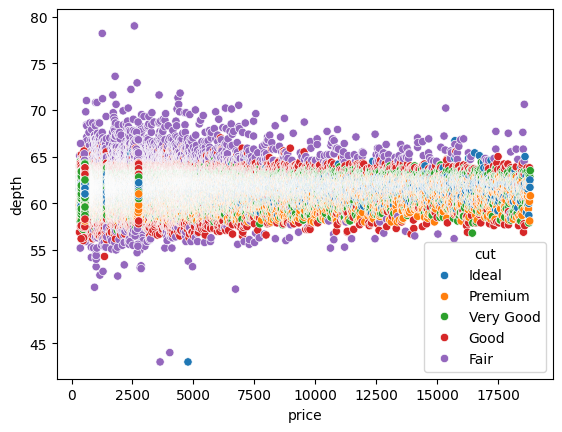

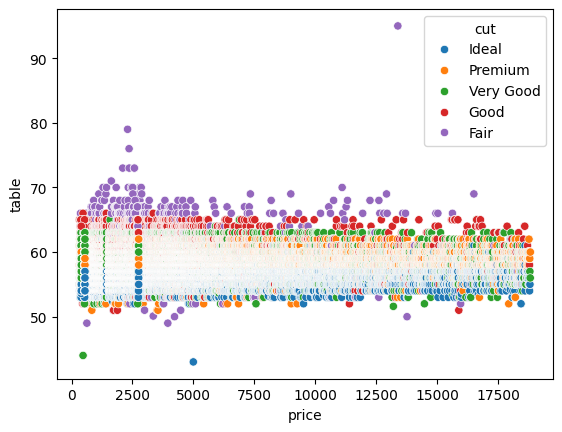

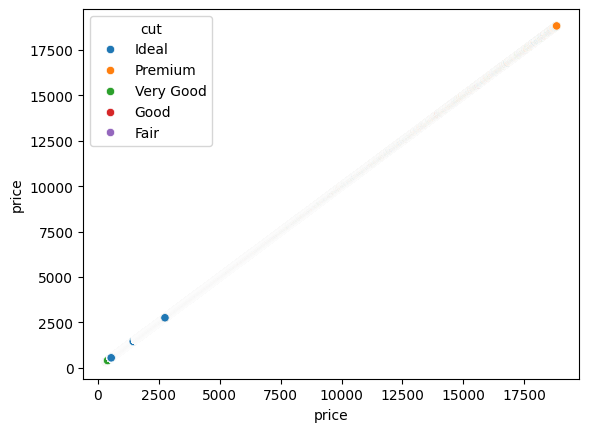

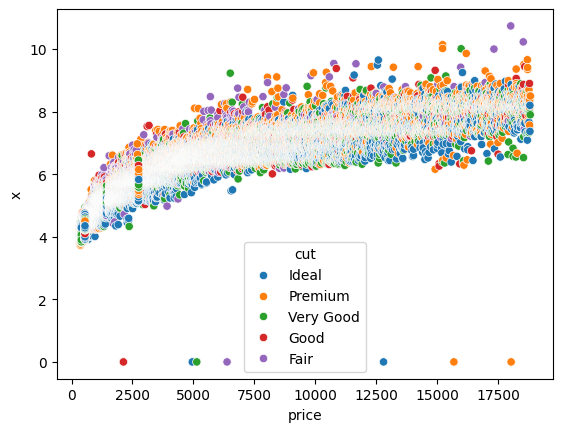

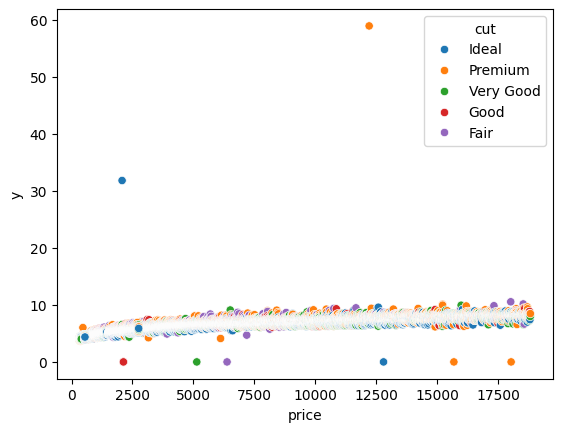

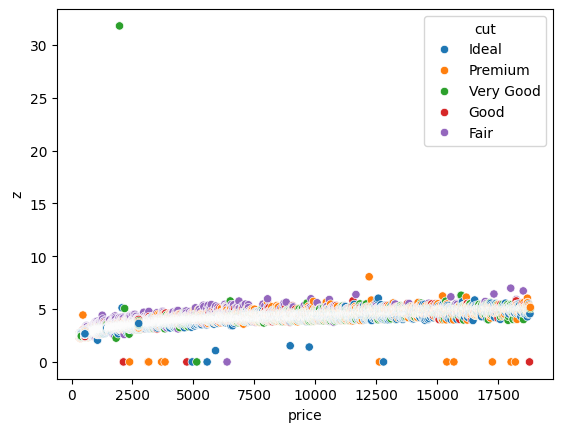

In [16]:
# Price değişkenine göre diğer değişkenlerin davranışını saçılım grafiği üzerinde görelim.
show_related(df)

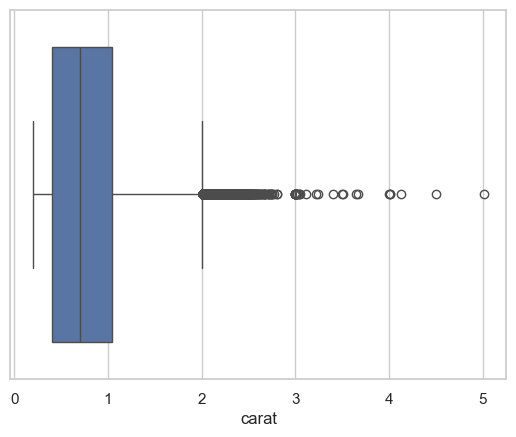

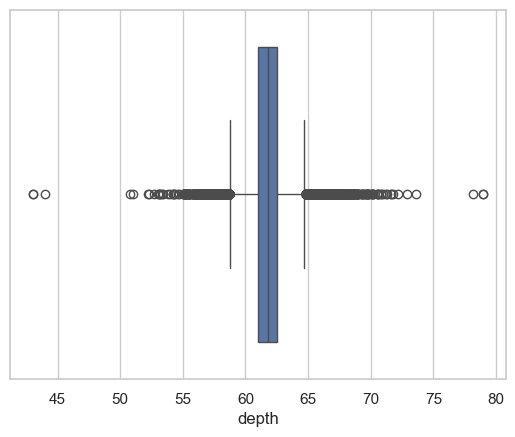

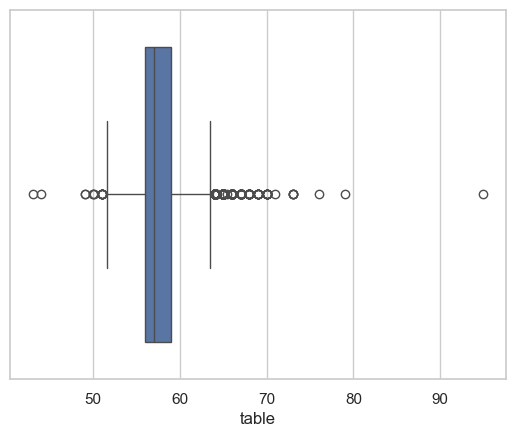

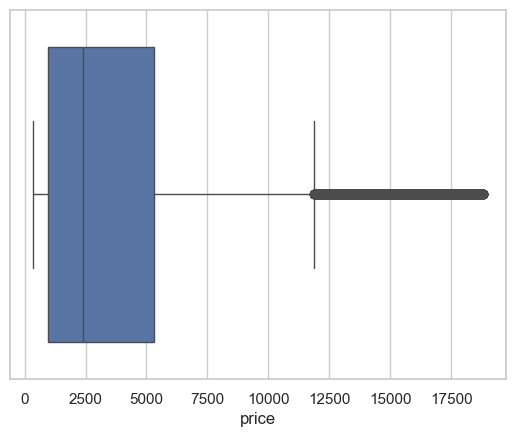

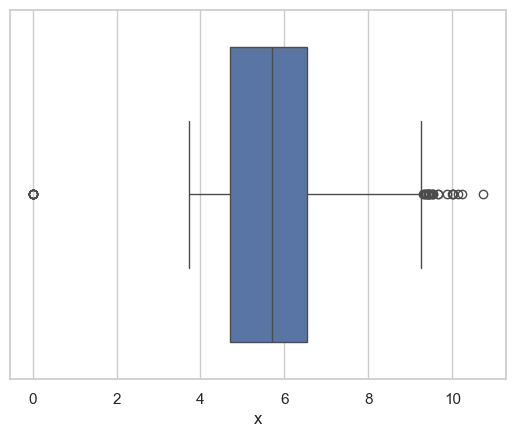

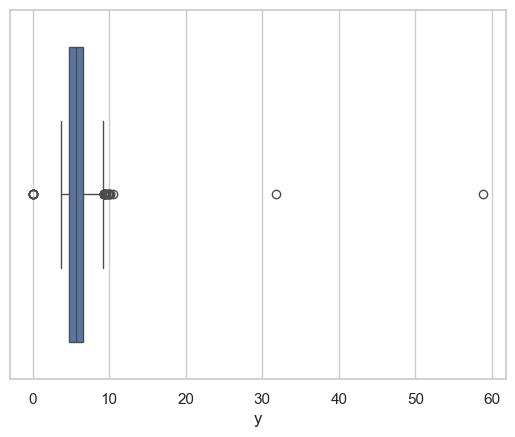

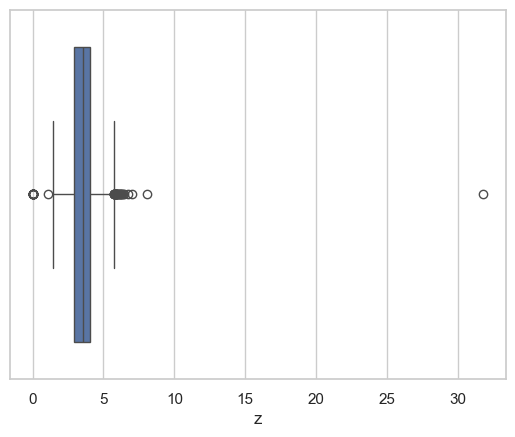

In [17]:
# Bu çalışmanın amacı aykırı değerleri tespit etmek.
# Bunun için en sık kullanılan yöntemlerden birisi kutu grafiği (box plot) yardımıyla her değişken için aykırı değerleri görüntüleyelim
show_outliers(df)

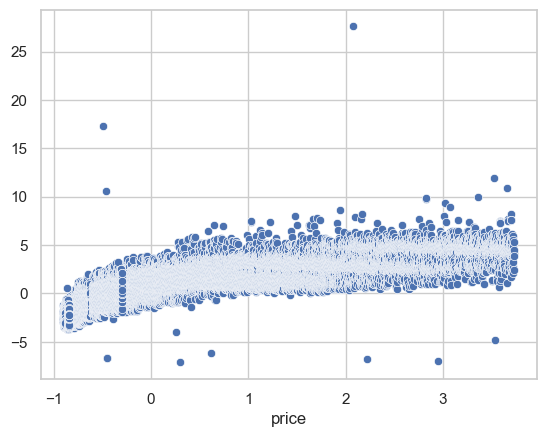

In [18]:
# Veriyi özet bir şekilde görselleştirebilmek için PCA yöntemine başvuruyorum.
df, df_ = scale_and_pca(df)

3. Interquartile Range
IQR (Interquartile Range) aykırı değer yakalamak için en sık kullanılan yöntemdir. Verideki değişkenleri bir bütün olarak değil parça parça olarak değerlendirir.Yani her bir değişken için ayrı ayrı analiz yapılması gerekir.


In [19]:
def IQR(dataframe, variable, q1=0.25, q3=0.75):
    quartile1 = dataframe[variable].quantile(q1)
    quartile3 = dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    outliers = [indx  for indx in df[variable].index if df.loc[indx, variable] > up_limit or df.loc[indx, variable] < low_limit]
    #dataframe["outliers"] = dataframe["outliers"].astype("category")
    return outliers

ıqr_outliers_default
inlier     47524
outlier     6416
Name: count, dtype: int64


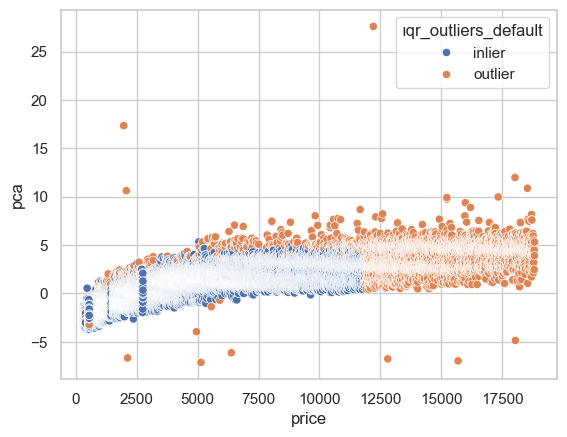

In [20]:
num_cols = df.select_dtypes(["int","float","int64","float64"])

ıqr_outliers_default = []
for col in num_cols:
    ıqr_outliers_default.extend(IQR(df,col))

df["ıqr_outliers_default"] = ["outlier" if inx in ıqr_outliers_default else "inlier" for inx in df.index]

print(df["ıqr_outliers_default"].value_counts())

ax = sns.scatterplot(data=df, x="price", y="pca", hue="ıqr_outliers_default")
plt.show()

Local Outlier Factor
LOF (Local Outlier Factor) veriyi bir bütün olarak değerlendirip bütün değişkenleri göz önünde bulundurarak her bir gözlemi uzayda bir noktaya yerleştirir.Bu sayede diğerlerinden daha uzak olan noktaları aykırı olarak tanımlar.

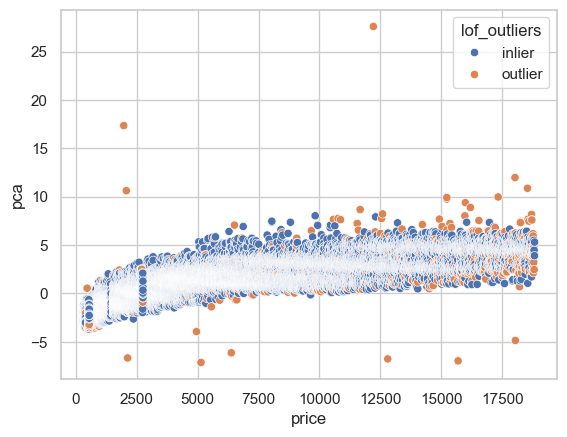

In [21]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
result = clf.fit_predict(df_)
df["lof_outliers"] = ["outlier" if val == -1 else "inlier"  for val in result]


hue_order = ["inlier", "outlier"]
ax = sns.scatterplot(data=df, x="price", y="pca", hue="lof_outliers",hue_order=hue_order)
plt.show()

Cluster Based Local Outlier Factor
CBLOF (Cluster Based Local Outlier Factor) LOF yönteminin özel bir versiyonudur.Önce veri kendi içerisinde kümelenir.Aykırılık skoru bu kümeler özelinde hesaplanır

cblof_outliers
0    48546
1     5394
Name: count, dtype: int64


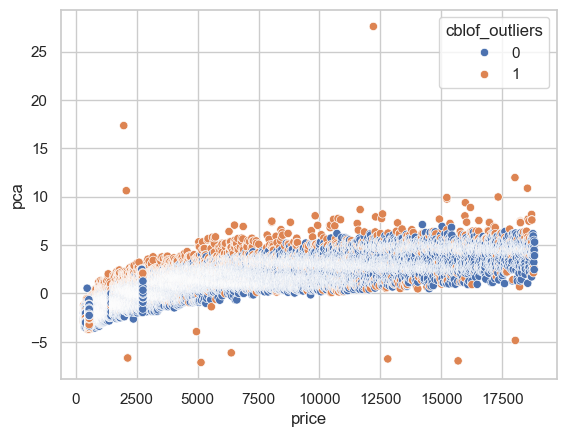

In [22]:
from pyod.models.cblof import CBLOF

cblof_clf = CBLOF(check_estimator=False, random_state=42)
cblof_clf.fit(df_)
df["cblof_outliers"] = cblof_clf.labels_
print(df["cblof_outliers"].value_counts())

ax = sns.scatterplot(data=df, x="price", y="pca", hue="cblof_outliers")
plt.show()

SVM yani Destek Vektör Makineleri sınıflandırma konularında kullanılan yaygın bir makine öğrenmesi algoritmasıdır. SVM'in sınıflandırma gücünden yararlanarak aykırı değer yakalama yapılabili

ocs_outliers
inlier     53396
outlier      544
Name: count, dtype: int64


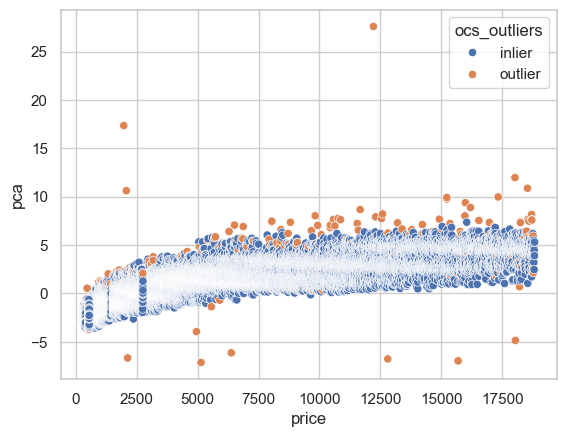

In [23]:
from sklearn.svm import OneClassSVM
ocs = OneClassSVM(nu=0.01)
result = ocs.fit_predict(df_)

df["ocs_outliers"] = ["outlier" if val == -1 else "inlier"  for val in result]
print(df["ocs_outliers"].value_counts())

ax = sns.scatterplot(data=df, x="price", y="pca", hue="ocs_outliers")
plt.show()